In [11]:
### First we handle our files ###
BASE_PATH = "../data"
FILE = "274_818_238"
tree_path = f"{BASE_PATH}/{FILE}.tree"
alignment_path = f"{BASE_PATH}/{FILE}.fas.alg"
table_path = f"{BASE_PATH}/{FILE}.tsv"
uniprot_path = f"../uniprot_2018_09.json"

### And we store them in different variables ###
try:
    with open(table_path, "r") as table_file:
        table_info = table_file.readlines()
except:
    print ("No table path.")
        
try:
    with open(alignment_path, "r") as alignment_file:
        alignment_info = alignment_file.read()
except:     
    print ("No alignment path.")
        
import json
uniprot_info = {}
with open(uniprot_path, "r") as uniprot_file:
    for line in uniprot_file:
        uniprot_entry = json.loads(line)
        uniprot_info.update(uniprot_entry)

In [15]:
### LOADING THE SPECIFIED TAG INFORMATION FROM OUR ALIGNMENT ###
def retrieve_features (feature_tag, table_file):
    uniprot_hit_hash = {}
    for line in table_file:
        hit_type = line.split("\t")[2]
        hit_name = line.split("\t")[1]
        if (hit_type == ("swissprot_best" or "swissprot_exact") and hit_name not in uniprot_hit_hash):
            features_newlist = []
#             for feature in uniprot_info[hit_name]["FT"]: # TO CHECK FEATURES WHEN WE PICK A NEW FILE MANUALLY
#                 print (feature)
            for feature in uniprot_info[hit_name]["FT"]:
                if feature["ft"] == feature_tag:
                    features_newlist.append(feature)
            if len(features_newlist) > 0:
                uniprot_hit_hash[hit_name] = features_newlist
    return uniprot_hit_hash

In [16]:
uniprot_hit_hash = retrieve_features("TOPO_DOM", table_info)
print (uniprot_hit_hash)

{'P77308': [{'ft': 'TOPO_DOM', 's': '1', 'e': '1', 'ann': 'Periplasmic. {ECO:0000255}.'}, {'ft': 'TOPO_DOM', 's': '33', 'e': '33', 'ann': 'Cytoplasmic. {ECO:0000255}.'}, {'ft': 'TOPO_DOM', 's': '126', 'e': '126', 'ann': 'Periplasmic. {ECO:0000255}.'}, {'ft': 'TOPO_DOM', 's': '157', 'e': '157', 'ann': 'Cytoplasmic. {ECO:0000255}.'}, {'ft': 'TOPO_DOM', 's': '221', 'e': '221', 'ann': 'Periplasmic. {ECO:0000255}.'}, {'ft': 'TOPO_DOM', 's': '270', 'e': '270', 'ann': 'Cytoplasmic. {ECO:0000255}.'}, {'ft': 'TOPO_DOM', 's': '301', 'e': '301', 'ann': 'Periplasmic. {ECO:0000255}.'}, {'ft': 'TOPO_DOM', 's': '323', 'e': '323', 'ann': 'Cytoplasmic. {ECO:0000255}.'}]}


In [18]:
### LOADING THE TREE WITH ETE3 ###    
from ete3 import PhyloTree, TreeStyle
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")

In [19]:
### TRANSFORMING THE SEQUENCE POSITIONS INTO ALIGNMENTS POSITIONS ###
def get_alignment_position (sequence_position, sequence):
    alignment_position = 0
    aminoacid_counted = 0
    for aminoacid in sequence:
        if aminoacid.isalpha():
            aminoacid_counted += 1
        if not (aminoacid_counted <= sequence_position or aminoacid_counted == 0):
            break
        alignment_position += 1
    return alignment_position

In [20]:
### GETTING A POSITIONS MATRIX FROM THE FEATURES IN OUR TREE ###
def get_positions_matrix (feature_hash, tree):
    position_matrix = []
    for unigene in feature_hash:
        unigene_sequence = (tree&unigene).sequence
        for feature in feature_hash[unigene]:
            feature_start = int(feature["s"])-1
            feature_end = int(feature["e"])-1
            alignment_feature_start = get_alignment_position(feature_start, unigene_sequence)
            alignment_feature_end = get_alignment_position(feature_end, unigene_sequence)
            for position in range (alignment_feature_start, alignment_feature_end+1):
                position_matrix.append(position)
    position_matrix = sorted(list(set(position_matrix)))
    return position_matrix

In [21]:
position_matrix = get_positions_matrix(uniprot_hit_hash, tree)
print (position_matrix)

[0, 32, 126, 163, 235, 399, 561, 590]


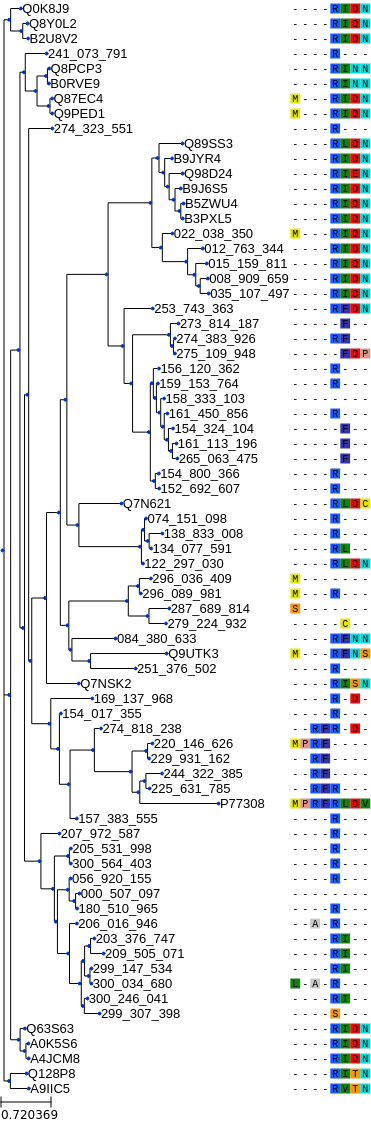

In [23]:
from ete3 import SeqMotifFace, TreeStyle, PhyloTree
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")

ts = TreeStyle()
ts.layout_fn = lambda x: True

for leaf in tree.iter_leaves():
    draw_position = 0
    for position in position_matrix:
        seqFace = SeqMotifFace(leaf.sequence[position], seq_format="seq")
        (tree&leaf.name).add_face(seqFace, draw_position, "aligned")
        draw_position += 1

tree.render('%%inline', tree_style = ts)
# tree.show(tree_style = ts)